In [17]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
import sys
import os
import random

from PIL import Image

import numpy as np
from torchvision import transforms


from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

path = os.path.dirname(os.getcwd())
sys.path.append(path)

import torch
import pandas as pd
from models.models import CLIngrModel

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Instantiate the model
num_ingr = 199
model = CLIngrModel(num_ingr=num_ingr)
model.load_state_dict(torch.load("../models/checkpoints/convlstm_ingr_log_da_v3.pth", map_location=device, weights_only=True))

<All keys matched successfully>

In [19]:
# Ensure the model is in evaluation mode
model.eval()

CLIngrModel(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(25088, 512, num_layers=2, batch_first=True, dropout=0.5)
  (fc1): Sequential(
    (0): Linear(in_features=512, out_features=256, bia

In [20]:
### Data Paths ###
dataset_path = '../../data/nutrition5k_reconstructed/'

image_path = os.path.join(dataset_path, 'images')
ingr_mata = os.path.join(dataset_path, 'metadata/ingredients_metadata.csv')

# Load the ingredient metadata
ingr_dataset_path = '../utils/data/test_labels_ingr_log.csv'
ingr_meta_df = pd.read_csv(ingr_mata)
ingr_df = pd.read_csv(ingr_dataset_path)

test_image_ids = ingr_df['id'].tolist()
# randomly sample 16 images
random.seed(1234)
sampled_images = random.sample(test_image_ids, 16)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

transformed_images = []
input_images = []
ingr_index = []
highest_ingr_name = []
highest_ingr_value = []

for image_id in sampled_images:
    # Prepare input image (e.g., a single image from a dataset)
    image_to_explain = f"../../data/nutrition5k_reconstructed/images/{image_id}.jpeg"
    
    image = Image.open(image_to_explain).convert('RGB')
    # Apply the transformations needed
    transformed_image = transform(image)
    input_image = transform_normalize(transformed_image)
    
    transformed_images.append(transformed_image)
    input_images.append(input_image)
    
    # Get the row for the dish
    dish_row = ingr_df[ingr_df['id'] == image_id]
    # Get all indices with ingredients > 0 for the dish
    dish_row = dish_row.drop(columns=['id', 'img_indx'])

    # Find the ingredient with the highest value
    highest_ingr = dish_row.iloc[0].idxmax()    # Ingredient with the highest value
    highest_value = dish_row.iloc[0].max()    # Maximum value in the row
    highest_ingr_index = dish_row.columns.get_loc(highest_ingr)
    
    ingr_index.append(highest_ingr_index)
    highest_ingr_name.append(highest_ingr)
    highest_ingr_value.append(highest_value)


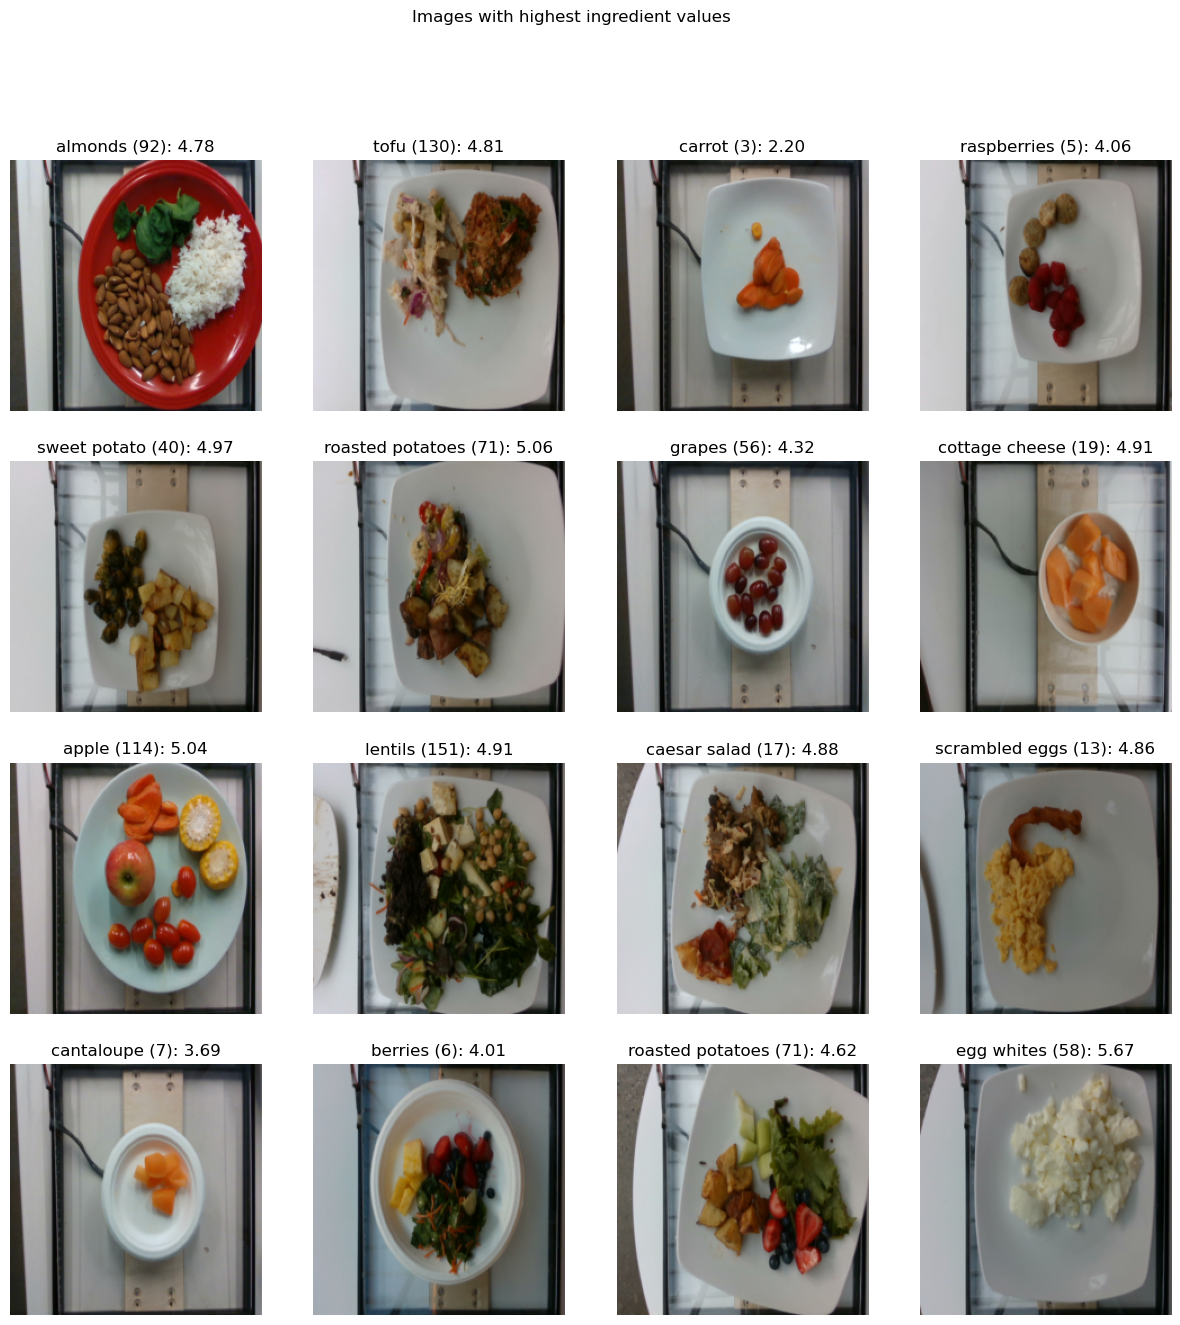

In [21]:
##### Visualize the images And Data #####
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
fig.suptitle('Images with highest ingredient values')

for i, ax in enumerate(axs.flat):
    ax.imshow(transformed_images[i].permute(1, 2, 0))
    ax.set_title(f"{highest_ingr_name[i]} ({ingr_index[i]}): {highest_ingr_value[i]:.2f}")
    ax.axis('off')
plt.show()

In [22]:
# Select the target convolutional layer for Grad-CAM
target_layer = [model.conv5]

# Instantiate Grad-CAM
cam = GradCAM(model=model, target_layers=target_layer)


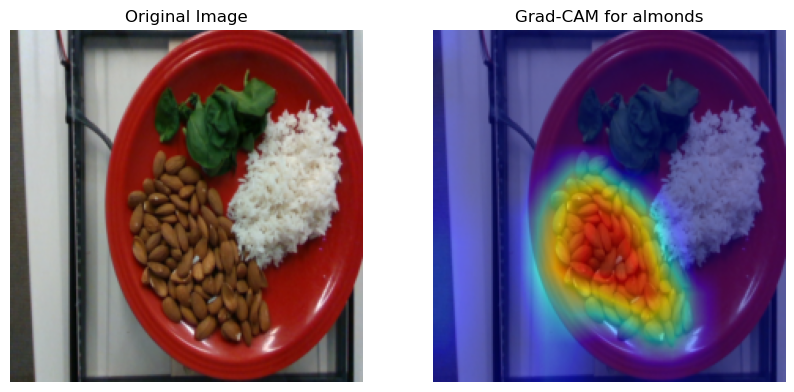

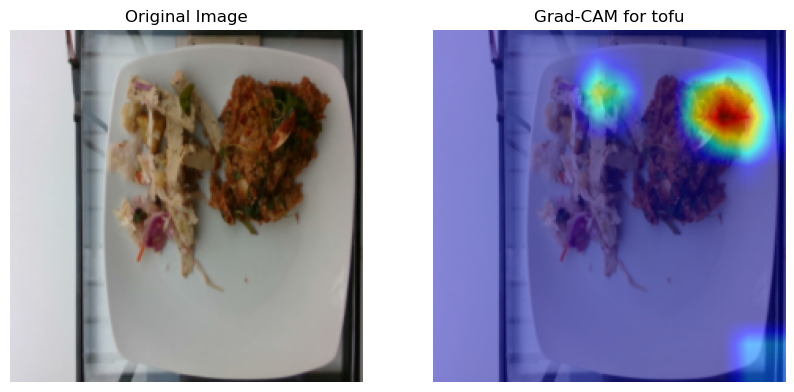

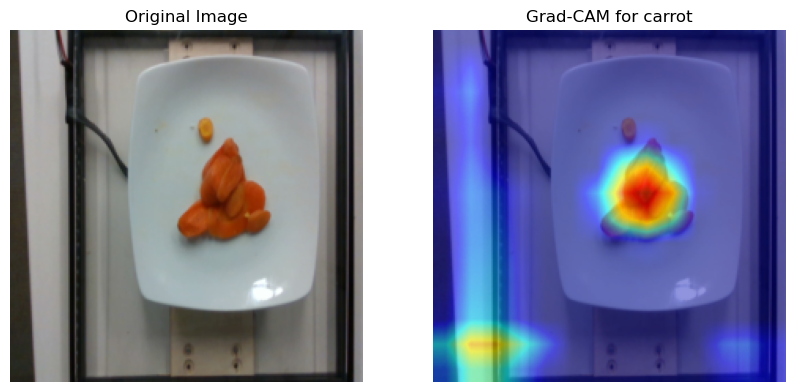

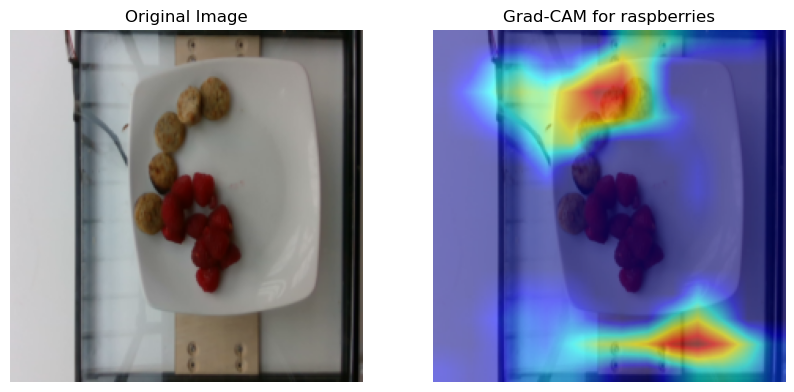

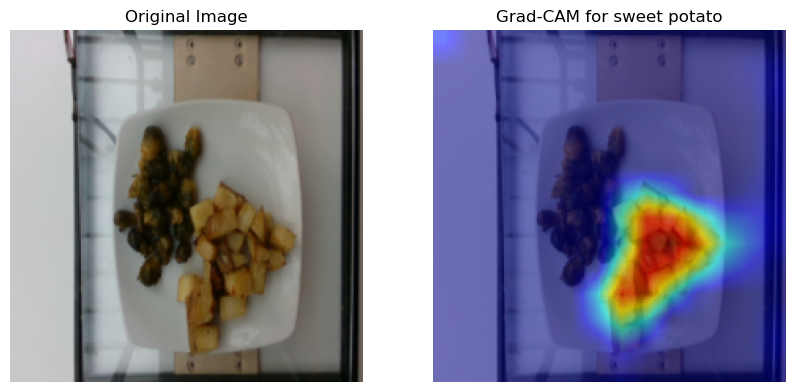

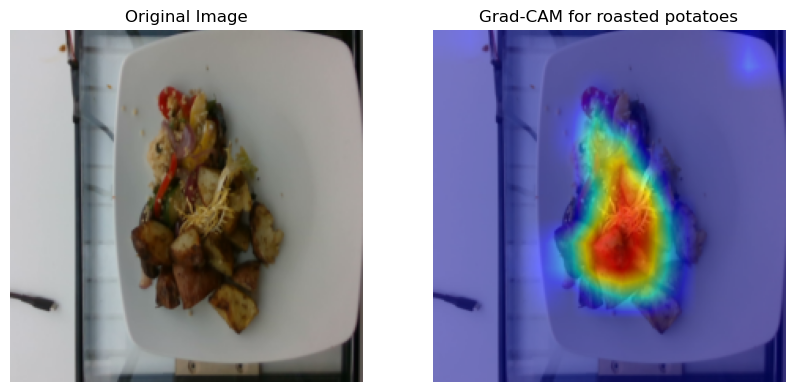

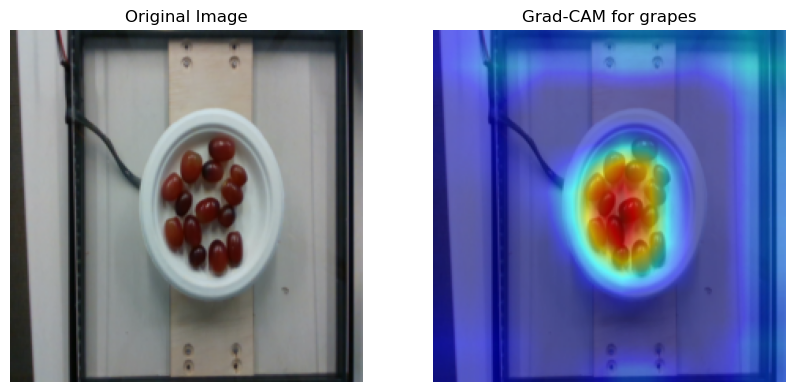

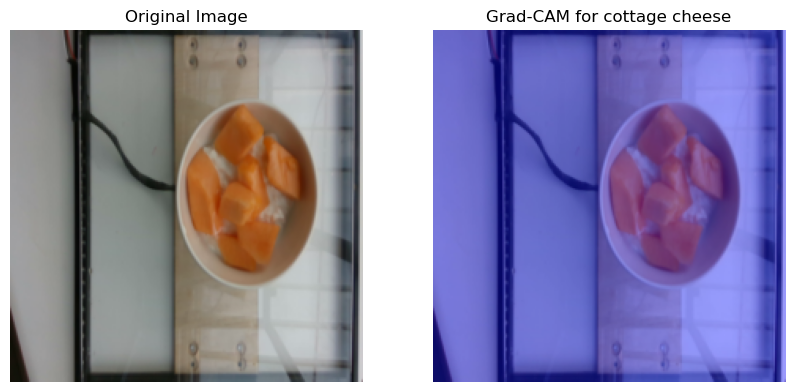

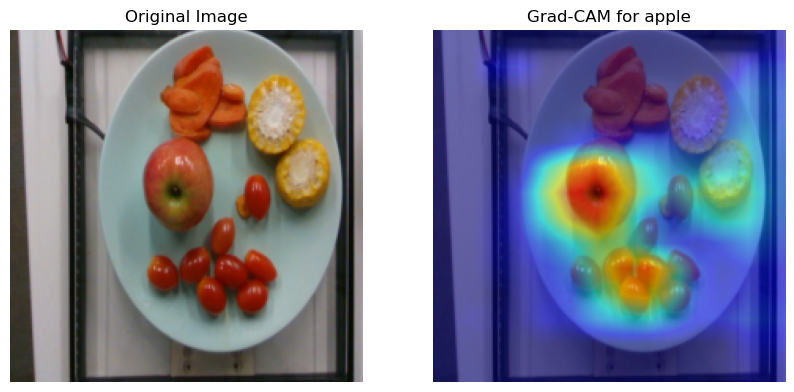

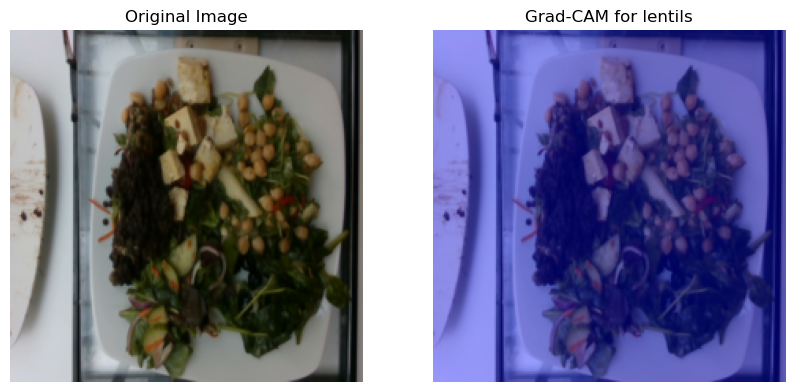

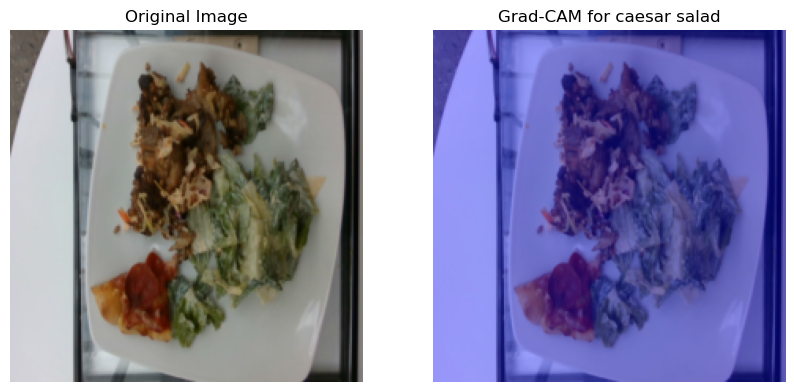

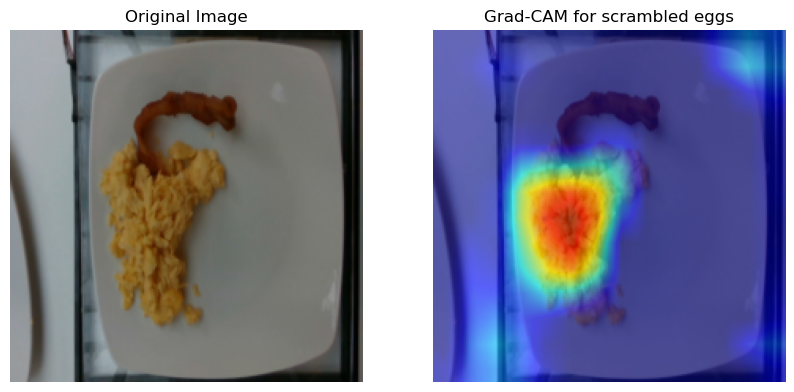

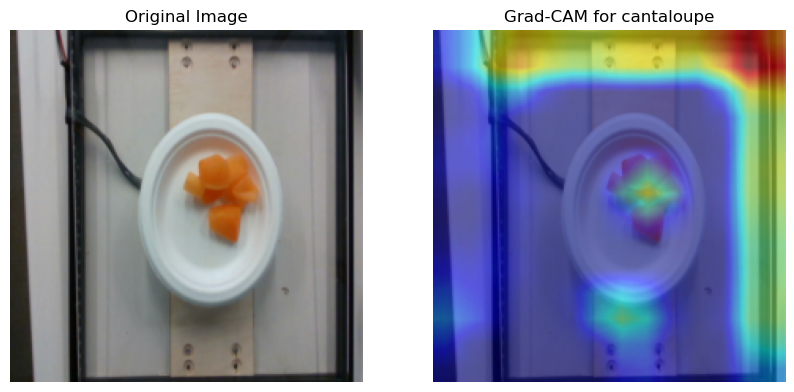

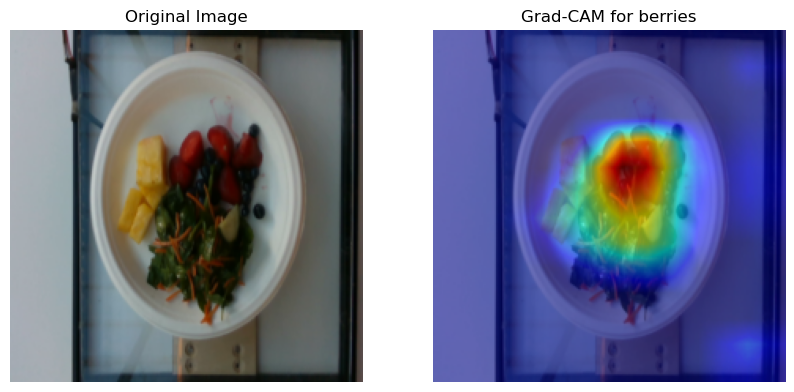

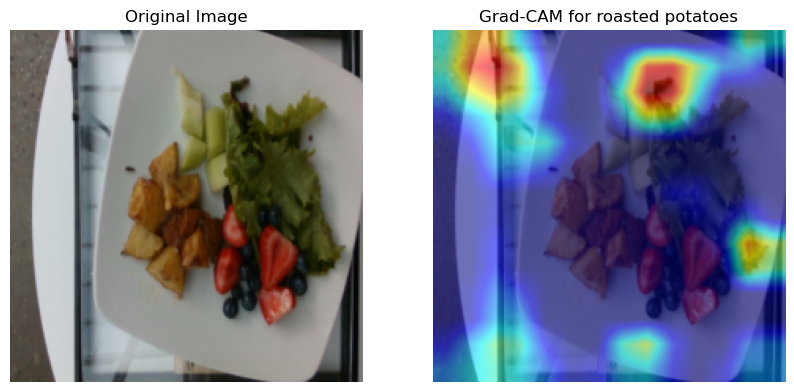

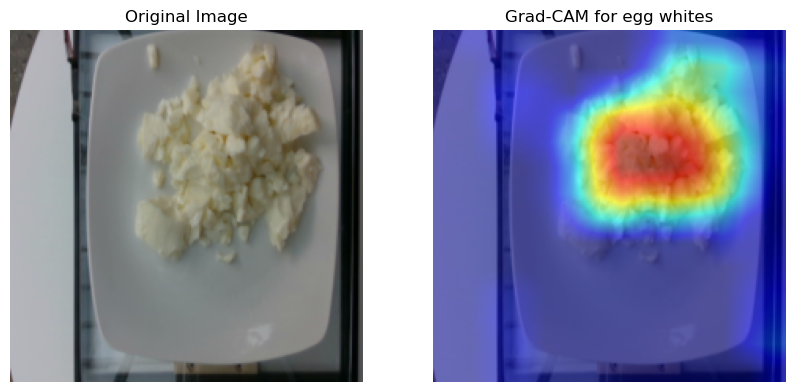

In [23]:
for (transformed_image, input_image, ingr_indx, highest_ingr_name) in zip(transformed_images, input_images, ingr_index, highest_ingr_name):
    # Compute Grad-CAM heatmap for the target ingredient (ingr_indx)
    targets = [ClassifierOutputTarget(ingr_indx)]
    grayscale_cam = cam(input_tensor=input_image.unsqueeze(0).to(device), targets = targets)
    grayscale_cam = grayscale_cam[0, :]
    
    # Convert input image to numpy array for visualization
    input_image_np = np.transpose(transformed_image.squeeze().cpu().detach().numpy(), (1,2,0))

    # Overlay Grad-CAM heatmap
    visualization = show_cam_on_image(input_image_np, grayscale_cam, use_rgb=True)

    # Display the original image and the Grad-CAM heatmap
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(input_image_np)
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    plt.axis('off')
    plt.title(f"Grad-CAM for {highest_ingr_name}")
    plt.show()